In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os, glob
import numpy as np
import datetime as dt
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem.lancaster import LancasterStemmer
pd.set_option('display.max_colwidth', None)

date = datetime.now().strftime("%Y-%m-%d")
firstdateoftheyear = datetime(int(datetime.now().strftime("%Y")), 1,1).strftime("%Y-%m-%d")
lastweek = (dt.date.today() + dt.timedelta(days=-dt.date.today().weekday()) - dt.timedelta(days = 7)).strftime("%Y-%m-%d")
last30days = (dt.date.today() + dt.timedelta(days=-dt.date.today().weekday()) - dt.timedelta(days = 30)).strftime("%Y-%m-%d")
# excludem = '^tokocrypto$|^indodax$|^pintu_id$|^pintuid$|^rekeningkuasset$|^rekuid$|^reku_id$|^kripto$|^crypto$'
# excludea = 'tokocrypto|indodax|pintu_id|pintuid|rekeningkuasset|rekuid|reku_id'
excludem = '^kitabisacom$|^kitabisa$|^orangbaik$'
excludea = 'kitabisacom'

In [2]:
def stopword(x):
  factory = StopWordRemoverFactory()
  swsas = factory.get_stop_words()
  swnltk = stopwords.words(['english','indonesian'])
  sw = [\
        '1','2','3','4','5','6','7','8','9','0',\
        'kitabisacom', 'kitabisa', 'orangbaik', 'bantu', 'donasi', 'terima', 'kasih', 'bantu', 'makasih', 'semoga', 'moga',\
        'kripto','crypto',\
        'bikin','biar','udah','kalo','kalo','gue','sih','emang','mohon','pake','en','dah','tau','zipmex',\
        'zipmexindonesia','gimana','loh','sampe','banget','kah','ga',\
        'asetmasadepan','cmc','aplikasipintu','salamtothemoon','deh', 'dm','hi', 'hai', 'kakak',\
        'pintuid','rekeningku','zipmex', 'pintu', 'upbit', 'tokocrypto','indodax', 'ya','token',\
        'ceo','tkolock','crypto','lock','udh','dont', 'hey', 'baby','rt', 'tuh','amp','sir','tko',\
        'bos','aja','gak','nih','nya','min','ud','cm','kak','bang','ntar','yg','nii', 'utc', 'x']+ swnltk\
        + list(STOPWORDS) + list(x[x['Type'].str.contains("Mention|Hashtag")]["word"].unique())
  swdf = pd.DataFrame(sw).drop_duplicates()
  swdf.columns = ["word"]
  swdf['word'] = swdf['word'].str.replace('[^\w\s]','', regex=True)
  return swdf

In [3]:
# topik = input("Pilih topik")
# date_begin = input("Pilih tanggal mulai (YYYY-MM-DD)")
# date_end = input("Pilih tanggal selesai (YYYY-MM-DD)")
# limit = input("berapa banyak data?")
# language = input("select lang:")

In [4]:
topik = "kitabisacom"
date_begin = "2019-06-01"
date_end = "2020-02-29"
limit = 1000
language = "in"
langs = language.split()

tweets_list1 = []
tweets_list2 = []
for i in langs:
    query = f"{topik} since:{date_begin} until:{date_end} lang:{i}"

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{query}').get_items()):
        if i>int(limit):
            break
        tweets_list1.append(tweet)
        tweets_list2.append([tweet.url, tweet.user.followersCount, tweet.user.friendsCount, tweet.user.verified])
        
    # Creating a dataframe from the tweets list above
    tl1 = pd.DataFrame(tweets_list1)
    tl2 = pd.DataFrame(tweets_list2,\
            columns = ['url', 'followers', 'friends', 'verified'])

    data = pd.merge(tl1, tl2, on = 'url')

    data.rename(columns = {'rawContent': 'text', 'sourceLabel':'source (platform)',\
        'replyCount':'replied','retweetCount':'retweeted','quoteCount':'quoted',\
        'likeCount':'liked', 'inReplyToTweetId': 'reply to'}, inplace=True)

    data['reply to'] = data['reply to'].fillna(0).apply(np.int64).apply(str).replace("0","")
    data['post type'] = np.where(data['quotedTweet'].notnull()==True, "share",\
        np.where((data['reply to']!="") & (data['quotedTweet'].isnull()==True),"reply","post"))

    data = data[~(data['url'].str.contains(excludea, case=False))][['date', 'url','text', 'lang', 'source (platform)', 'verified', 'post type', 'reply to',\
        'replied','retweeted', 'quoted', 'liked', 'followers', 'friends']]
    # return data

In [5]:
wordings = data.copy()

wordings['word'] = wordings['text'].str.lower()\
    .str.replace('#|#\n',' #', regex=True).str.replace('@|@\n',' @', regex=True)\
    .str.split()
wordings = wordings.explode('word')
wordings = wordings[~(wordings['word'].str.contains('https'))]
wordings['word'] = wordings['word'].str.replace('[^A-Za-z #@]',' ', regex=True)
wordings = wordings[wordings['word'].str.contains(" ")==False]
wordings['Type'] = np.where(wordings['word'].str.startswith("#"), "hashtag",\
    np.where(wordings['word'].str.contains("@"), "mention", "word"))

swdf = stopword(wordings)
st = LancasterStemmer()
factory = StemmerFactory()
indo = factory.create_stemmer()

wordings_new = pd.merge(wordings, swdf, how='outer', on = 'word', indicator=True).drop_duplicates()
wordings_new['word'] = np.where((wordings_new['lang']=='en') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: st.stem(y)),\
    np.where((wordings_new['lang']=='in') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: indo.stem(y)),wordings_new['word']))
wordings_new = wordings_new[(wordings_new['_merge'] == 'left_only') & (wordings_new['Type']=="word")].drop(columns="_merge")
hashnmention_new = wordings[(wordings['Type'] != 'word') & ~(wordings['word'].str.replace('@|#','', regex=True).str.contains(excludem))]

ov_wordings_word = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word','count_url']]
ov_wordings_word.columns = ['word', 'count_word']
ov_wordings_total = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()

ov_wordings = pd.merge(ov_wordings_total,ov_wordings_word).sort_values(by='word', ascending=False)\
    [['word','count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_wordings.rename(columns = {'count_word':'total word',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_hash_total = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash_word = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_hash_word.columns = ['word', 'count_word']

ov_hash = pd.merge(ov_hash_total,ov_hash_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash['word'] = ov_hash['word'].replace("#","", regex=True)

ov_hash.rename(columns = {'word': 'hashtag', 'count_word':'total hashtags',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_mention_total = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention_word = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_mention_word.columns = ['word', 'count_word']

ov_mention = pd.merge(ov_mention_total,ov_mention_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention['word'] = ov_mention['word'].replace("@","", regex=True)

ov_mention.rename(columns = {'word': 'mention', 'count_word':'total mentions',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

# return wordings_new, hashnmention_new, ov_wordings, ov_hash, ov_mention

In [6]:
ov_wordings.sort_values(by='total word', ascending = False).head(10)

,word,total word,retweeted,quoted,liked
237,bude,166,4569.0,629.0,21858.0
1249,selamat,91,3.0,0.0,83.0
47,alhamdulillah,89,5.0,1.0,309.0
1240,sehat,46,7.0,0.0,73.0
139,bantu,40,211.0,4.0,295.0
335,dana,36,20.0,3.0,37.0
178,berkah,36,0.0,0.0,12.0
465,galang,28,66.0,0.0,327.0
240,budeee,24,0.0,0.0,1.0
239,budee,22,0.0,0.0,23.0


In [7]:
ov_hash.sort_values(by='total hashtags', ascending = False).head(10)

,hashtag,total hashtags,retweeted,quoted,liked
32,gurupesisirsejahtera,3,0,0,0
47,pedulipesisir,2,0,0,0
50,pentahelix,2,4,0,5
24,donasi,2,0,0,0
46,pburusanbersama,2,4,0,5
60,temandana,2,2,6,1
5,banten,2,0,1,3
9,barutau,1,0,0,0
13,bkmmmakassar,1,0,0,2
12,bisabangunjembatan,1,1,0,3


In [8]:
ov_mention.sort_values(by='total mentions', ascending = False).head(10)

,mention,total mentions,retweeted,quoted,liked
47,budesumiyati,481,9,0,526
245,ryobodat,26,0,0,9
283,wordfangs,25,0,0,10
269,thepanturas,24,0,0,9
172,listentofeast,24,0,0,9
189,najwashihab,18,1,0,4
178,matanajwa,18,16,1,349
110,gojekindonesia,15,4,0,11
290,ylbhi,15,1,0,2
13,alghifaqsa,12,1,0,0


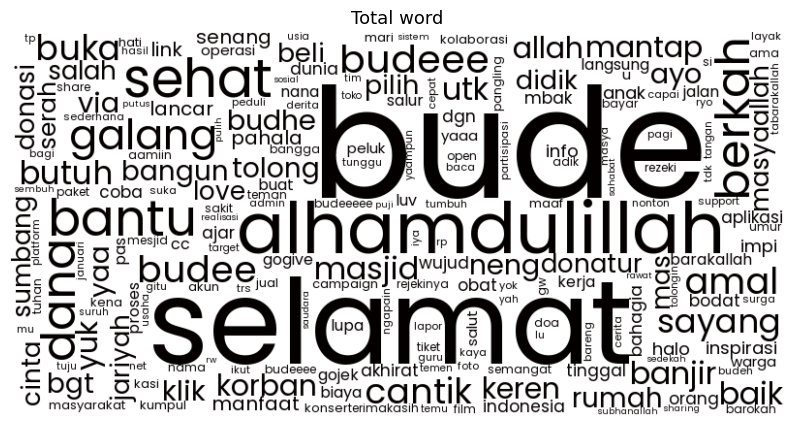

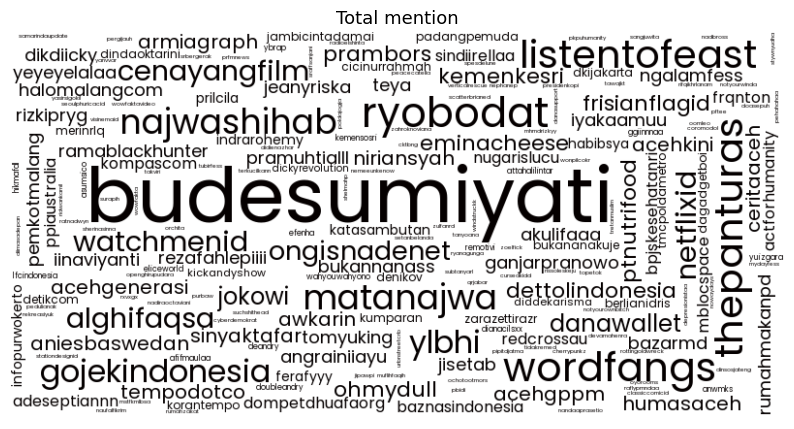

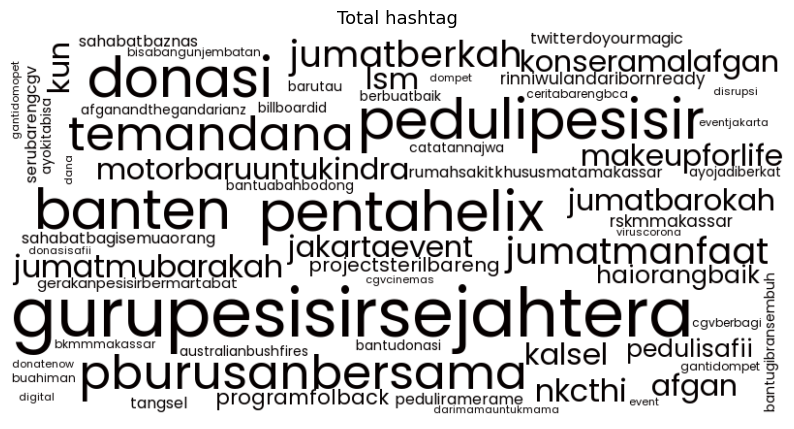

In [9]:
def black(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def green(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(125, 62%, 37%)")

def blue(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(240,100%,50%)")

def white(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 100%)")

font = 'D:/Documents/Programming/Python/Sentiments/Sources/Font/Poppins-Regular.ttf'
words_max = 200

ov_wordings_dict = ov_wordings.set_index('word').to_dict()['total word']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_wordings_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total word", fontsize=13)
plt.axis('off')
plt.show()

ov_mention_dict = ov_mention.set_index('mention').to_dict()['total mentions']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_mention_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total mention", fontsize=13)
plt.axis('off')
plt.show()

ov_hash_dict = ov_hash.set_index('hashtag').to_dict()['total hashtags']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_hash_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total hashtag", fontsize=13)
plt.axis('off')
plt.show()

In [11]:
wordings_new[(wordings_new['word'].str.contains(ov_wordings.sort_values(by='total word', ascending = False).iat[0,0], case = False))].sort_values(by='followers', ascending = False).head()

,date,url,text,lang,source (platform),verified,post type,reply to,replied,retweeted,quoted,liked,followers,friends,word,Type
2553,2020-02-22 08:48:59+00:00,https://twitter.com/Santi_nya/status/1231138805752614912,@BudeSumiyati @kitabisacom Selamat bude ku tercinta 🤗🤗🤗,in,Twitter for iPhone,False,reply,1231079245322964992,0.0,0.0,0.0,28.0,848400.0,456.0,bude,word
2591,2020-02-22 06:35:47+00:00,https://twitter.com/adelladellaide/status/1231105287005753344,@BudeSumiyati @kitabisacom Bangga sama bude 😘,tl,Twitter for iPhone,False,reply,1231079245322964992,0.0,1.0,0.0,4.0,824474.0,610.0,bude,word
2661,2020-02-22 04:52:19+00:00,https://twitter.com/BudeSumiyati/status/1231079245322964993,Berkat doa juga donasi dari teman-teman semua akhirnya pembangunan masjidnya selesai dengan baik dan lancar. Bude mengucapkan terima kasih untuk teman-teman dan @kitabisacom. Semoga kebaikan dan cinta kalian dibalas dengan yang lebih indah lagi. https://t.co/kfYgQow1Q9,in,Twitter for Android,False,post,,1119.0,4567.0,629.0,21772.0,792407.0,603.0,bude,word
4687,2020-02-22 06:26:10+00:00,https://twitter.com/isnansayyidinaa/status/1231102865772437505,@BudeSumiyati @kitabisacom MasyaAllah sehat trs budee 😇,in,Twitter for Android,False,reply,1231079245322964992,0.0,0.0,0.0,23.0,149739.0,1288.0,budee,word
2636,2020-02-22 05:18:49+00:00,https://twitter.com/dewahoya/status/1231085917407834112,@BudeSumiyati @kitabisacom Selamat ya bude \n\nSemoga rejekinya awet terus sepanjang masa ❤️,in,Twitter for iPhone,False,reply,1231079245322964992,0.0,0.0,0.0,25.0,127992.0,814.0,bude,word


In [13]:
hashnmention_new[(hashnmention_new['word'].str.contains(ov_mention.iat[0,0], case = False))].sort_values(by='friends', ascending = False).head()

,date,url,text,lang,source (platform),verified,post type,reply to,replied,retweeted,quoted,liked,followers,friends,word,Type
208,2020-02-22 10:27:44+00:00,https://twitter.com/heniunique/status/1231163657226113024,@BudeSumiyati @kitabisacom Alhamdulillah menambah karma baik.,in,Twitter for Android,False,reply,1231079245322964992,0,0,0,1,13359,9262,@budesumiyati,mention
503,2020-02-22 05:03:48+00:00,https://twitter.com/tictacuu/status/1231082135798202368,@BudeSumiyati @kitabisacom Alhamdulillah,in,Twitter for iPhone,False,reply,1231079245322964992,0,0,0,0,12046,7574,@budesumiyati,mention
260,2020-02-22 08:14:00+00:00,https://twitter.com/PFTee/status/1231130000780193794,@BudeSumiyati @dagadgetboi @kitabisacom Selamat. Ada IMB nya ga? 😁\nhttps://t.co/Go5J0HI1G8,in,Twitter for Android,False,share,1231079245322964992,1,0,0,1,4643,5007,@budesumiyati,mention
134,2020-02-22 14:35:26+00:00,https://twitter.com/PFTee/status/1231225994867986433,@AntoniusMade @BudeSumiyati @dagadgetboi @kitabisacom 👍Harusnya begitu,in,Twitter for Android,False,reply,1231215557577338880,0,0,0,0,4643,5007,@budesumiyati,mention
216,2020-02-22 09:59:07+00:00,https://twitter.com/alter_keduwa/status/1231156455706746880,@BudeSumiyati @kitabisacom Alhmdulilh...\nSaranghae bude https://t.co/bBUaKSA1Qh,in,Twitter for Android,False,reply,1231079245322964992,0,0,0,0,879,5005,@budesumiyati,mention


In [12]:
hashnmention_new[(hashnmention_new['word'].str.contains(ov_hash.iat[0,0], case = False))].sort_values(by='friends', ascending = False).head()

,date,url,text,lang,source (platform),verified,post type,reply to,replied,retweeted,quoted,liked,followers,friends,word,Type
831,2020-01-23 04:31:45+00:00,https://twitter.com/NiatBaikSinergi/status/1220202435022450688,Langkah kecil ini menyimpan sebuah harapan yang besar untuk membantu pendidikan tertinggal di pesisir. #GuruPesisirSejahtera #GerakanPesisirBermartabat #PeduliPesisir @kitabisacom https://t.co/EBLvTiGovW,in,Twitter for Android,False,reply,1220201845211070464,1,0,0,0,4,69,#gurupesisirsejahtera,hashtag
832,2020-01-23 04:29:24+00:00,https://twitter.com/NiatBaikSinergi/status/1220201845211070464,Kami bertemu Pak Sholeh di rumahnya untuk memberi bingkisan. Pak Sholeh dan empat guru lainnya sangat berterimakasih atas bantuan yang diberikan.\n5 guru madrasah Baiturrohman akan mendapatkan gaji guru yang layak selama satu tahun ke depan.\n@kitabisacom #GuruPesisirSejahtera https://t.co/1IrXB5Jq6y,in,Twitter for Android,False,reply,1220201400090550272,1,0,0,0,4,69,#gurupesisirsejahtera,hashtag
833,2020-01-23 04:27:38+00:00,https://twitter.com/NiatBaikSinergi/status/1220201400090550272,"Alhamdulillah pada tanggal 16 Januari 2020, Tim Niat Baik Sinergi Foundation telah menyalurkan bantuan gaji guru bulan pertama dan sembako kepada 5 guru di madrasah DTA Baiturrohman. @kitabisacom #GuruPesisirSejahtera #PeduliPesisir https://t.co/jNHWGksDiI",in,Twitter for Android,False,post,,1,0,0,0,4,69,#gurupesisirsejahtera,hashtag
